# Bank Account Ownership Analysis


## Table of Contents
- [Business Understanding](#business-understanding)
- [Data Understanding](#data-understanding)
    - [Data collection & cleaning](#1-data-collection--cleaning)
    - [Exploratory Data Analysis](#2-exploratory-data-analysis)
- [Data Preparation](#Data-Preparation)
    - [Encode categorical variables](#encode-categorical-variables)
    - [Transform data](#Transform-data)
- [Modeling](#Modeling)
    - [Linear Regression](#linear-regression)
    - [Classification Models](#classification-models)
        - [Logistic Regression](#1-logistic-regression)
        - [Random Forest](#2-random-forest)
        - [XGBoost](#3-xgboost-model)
- [Evaluation](#evaluation)


## Business Understanding

### Introduction

Financial inclusion stands as an essential element for economic progress in the globalized world. Having a bank account enables people to achieve financial stability and opens up new economic opportunities. Access to bank accounts enables people to accumulate savings and handle financial transactions while enabling full economic participation. What elements affect the access to this vital banking instrument? 

### Business Objectives 
- Investigate the effect of economic indicators on bank account access. 
- Investigate the effect of gender and education levels on bank account access.
- Use different machine learning models to predict bank account access. 

### Business Questions
- Does living in a rich country automatically mean you'll have a bank account?
- Are there global differences in bank account ownership between men and women, lower educated and higher educated individuals, and what might explain them?
- Can we predict bank account access based on income, gender and education levels? 


### Goals
- Reveal how economic factors, social dynamics and education levels connect with financial inclusion.
- Use regression models to predict a continuous variable like bank account access rate.
- Use classification models to predict a binary variable like bank account access.

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


### Libraries installed to run this program

matplotlib==3.10.1; 
numpy==2.2.5; 
pandas==2.2.3; 
pandas_datareader==0.10.0; 
pycountry==24.6.1; 
scikit_learn==1.6.1; 
seaborn==0.13.2; 
shap==0.47.1; 
xgboost==3.0.0

to install the libraries, go to the terminal and type: `pip install -r requirements.txt`


## Data Understanding

### 1. Data collection & cleaning


Datasets to download (All from World Bank):

1. Economic Indicators (WDI) 2021:
- [GDP per capita (NY.GDP.PCAP.CD)](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=US)

GDP per capita is gross domestic product divided by midyear population. Data are in current U.S. dollars.
- [inflation (FP.CPI.TOTL.ZG)](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?locations=US) 

Inflation as measured by the consumer price index reflects the annual percentage change in the cost to the average consumer.
- country: country name 
- code: country ISO code

2. Bank Account Access ([Global Findex Database 2021](https://www.worldbank.org/en/publication/globalfindex/Data)):

- Country name 

- Country code: country ISO code 

- Year   

- Region: country geographic regions 
                                             
- Income group: 

country income classifications by income level based on GNI per capita in current USD (https://blogs.worldbank.org/en/opendata/new-world-bank-country-classifications-income-level-2021-2022)                                     
- Account (% age 15+): 

The percentage of adults who report having an account (by themselves or together with someone else) at a bank or another type of financial institution.                                
- Account, female (% age 15+): 

The percentage of female adults who report having an account.                        
- Account, male (% age 15+):

The percentage of male adults who report having an account.                          
- Account, primary education or less (% ages 15+): 

The percentage of adults who have completed primary education or less who have an account.                          
- Account, secondary education or more (% ages 15+): 

The percentage of adults who have completed secondary education or more who have an account.                           


### 1.1 Download & clean economic data in 2021

Download the GDP_per_capita and inflation data from World Bank manually and save them in one file named 'economic_data.csv'.

- [GDP per capita (NY.GDP.PCAP.CD)](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=US)
                                    
- [inflation (FP.CPI.TOTL.ZG)](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?locations=US)
                                                                   

In [2]:
# Load GDP and inflation data and merge them into one DataFrame

economic_data = pd.read_csv('economic_data.csv')
economic_data.head()

,country,code,GDP_per_capita,inflation
0,Aruba,ABW,27200.061080,NaN
1,Africa Eastern and Southern,AFE,1522.590088,7.240978
2,Afghanistan,AFG,356.496214,5.133203
3,Africa Western and Central,AFW,1747.840549,3.745700
4,Angola,AGO,1925.874661,25.754295


In [3]:
# check the data types and null values
economic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         266 non-null    object 
 1   code            266 non-null    object 
 2   GDP_per_capita  258 non-null    float64
 3   inflation       224 non-null    float64
dtypes: float64(2), object(2)
memory usage: 8.4+ KB


In [4]:
# check for null values in the dataset
economic_data.isnull().sum()

country            0
code               0
GDP_per_capita     8
inflation         42
dtype: int64

### clean data

In [5]:
# drop rows with missing values
economic_data.dropna(inplace=True)

# check again for missing values
economic_data.isnull().sum()

country           0
code              0
GDP_per_capita    0
inflation         0
dtype: int64

In [6]:
# check duplicates
economic_data.duplicated().sum()

0

In [7]:
# check the description of the dataset
economic_data.describe()

,GDP_per_capita,inflation
count,223.000000,223.000000
mean,15589.711518,7.434546
std,21656.181583,27.086992
min,214.091455,-0.772844
25%,2279.640442,2.304466
50%,6222.621644,3.653533
75%,18136.827795,5.173626
max,133711.794400,359.093041


### 1.2 Download & clean the Bank Account Access Data ([Global Findex Database 2021](https://www.worldbank.org/en/publication/globalfindex/Data)):

Download the excel file (https://www.worldbank.org/en/publication/globalfindex/Data) and save it as 'bank_account_access_data.xlsx' and select the required columns manually.

In [8]:
# load credit access data from excel file

bank_account_access_data = pd.read_excel('bank_account_access_data.xlsx')
bank_account_access_data.head()

,Country name,Country code,Year,Region,Income group,Account (% age 15+),"Account, female (% age 15+)","Account, male (% age 15+)","Account, primary education or less (% ages 15+)","Account, secondary education or more (% ages 15+)"
0,Afghanistan,AFG,2011,South Asia,Low income,0.090050,0.026162,0.154155,0.053173,0.299704
1,Afghanistan,AFG,2014,South Asia,Low income,0.099610,0.038124,0.157847,0.048285,0.226009
2,Afghanistan,AFG,2017,South Asia,Low income,0.148933,0.071607,0.225365,0.088877,0.305588
3,Afghanistan,AFG,2021,South Asia,Low income,0.096538,0.046973,0.147850,0.051778,0.234031
4,Albania,ALB,2011,Europe & Central Asia (excluding high income),Upper middle income,0.282681,0.226726,0.336647,0.150617,0.362444


In [9]:
# filter data in 2021
bank_account_access_data = bank_account_access_data[bank_account_access_data['Year'] == 2021]
bank_account_access_data.head()


,Country name,Country code,Year,Region,Income group,Account (% age 15+),"Account, female (% age 15+)","Account, male (% age 15+)","Account, primary education or less (% ages 15+)","Account, secondary education or more (% ages 15+)"
3,Afghanistan,AFG,2021,South Asia,Low income,0.096538,0.046973,0.147850,0.051778,0.234031
7,Albania,ALB,2021,Europe & Central Asia (excluding high income),Upper middle income,0.441742,0.456861,0.425852,0.343556,0.565037
11,Algeria,DZA,2021,Middle East & North Africa (excluding high inc...,Lower middle income,0.440970,0.311915,0.568304,0.389862,0.462316
17,Argentina,ARG,2021,Latin America & Caribbean (excluding high income),Upper middle income,0.716271,0.737532,0.695619,0.570962,0.796932
21,Armenia,ARM,2021,Europe & Central Asia (excluding high income),Upper middle income,0.553477,0.521827,0.593753,0.445578,0.567015


In [10]:
# check the data types and null values
bank_account_access_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 3 to 657
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country name                                       145 non-null    object 
 1   Country code                                       145 non-null    object 
 2   Year                                               145 non-null    int64  
 3   Region                                             129 non-null    object 
 4   Income group                                       126 non-null    object 
 5   Account (% age 15+)                                145 non-null    float64
 6   Account, female (% age 15+)                        145 non-null    float64
 7   Account, male (% age 15+)                          145 non-null    float64
 8   Account, primary education or less (% ages 15+)    145 non-null    float64
 9   Account, second

### data cleaning

In [11]:
# data cleaning
bank_account_access_data.columns = ['country', 'code', 'year', 'region', 'income_group', 
            'account_total', 'account_female', 'account_male',
            'account_primary_edu', 'account_secondary_edu']

# set country as index
bank_account_access_data.set_index('country', inplace=True)

bank_account_access_data.head()



,code,year,region,income_group,account_total,account_female,account_male,account_primary_edu,account_secondary_edu
country,,,,,,,,,
Afghanistan,AFG,2021,South Asia,Low income,0.096538,0.046973,0.147850,0.051778,0.234031
Albania,ALB,2021,Europe & Central Asia (excluding high income),Upper middle income,0.441742,0.456861,0.425852,0.343556,0.565037
Algeria,DZA,2021,Middle East & North Africa (excluding high inc...,Lower middle income,0.440970,0.311915,0.568304,0.389862,0.462316
Argentina,ARG,2021,Latin America & Caribbean (excluding high income),Upper middle income,0.716271,0.737532,0.695619,0.570962,0.796932
Armenia,ARM,2021,Europe & Central Asia (excluding high income),Upper middle income,0.553477,0.521827,0.593753,0.445578,0.567015


In [12]:
# Convert decimals to percentages
pct_cols = ['account_total', 'account_female', 'account_male', 
            'account_primary_edu', 'account_secondary_edu']
bank_account_access_data[pct_cols] = (bank_account_access_data[pct_cols].values *100).astype(int)

bank_account_access_data.head()

,code,year,region,income_group,account_total,account_female,account_male,account_primary_edu,account_secondary_edu
country,,,,,,,,,
Afghanistan,AFG,2021,South Asia,Low income,9,4,14,5,23
Albania,ALB,2021,Europe & Central Asia (excluding high income),Upper middle income,44,45,42,34,56
Algeria,DZA,2021,Middle East & North Africa (excluding high inc...,Lower middle income,44,31,56,38,46
Argentina,ARG,2021,Latin America & Caribbean (excluding high income),Upper middle income,71,73,69,57,79
Armenia,ARM,2021,Europe & Central Asia (excluding high income),Upper middle income,55,52,59,44,56


In [13]:
# Add % signs to column names for clarity
bank_account_access_data = bank_account_access_data.rename(columns={
    'account_total': 'account_total (%)',
    'account_female': 'account_female (%)',
    'account_male': 'account_male (%)',
    'account_primary_edu': 'account_primary_edu (%)',
    'account_secondary_edu': 'account_secondary_edu (%)'
})

# Drop the year column
bank_account_access_data.drop(columns = ['year'], inplace = True)

# check missing values
bank_account_access_data.isnull().sum()

code                          0
region                       16
income_group                 19
account_total (%)             0
account_female (%)            0
account_male (%)              0
account_primary_edu (%)       0
account_secondary_edu (%)     0
dtype: int64

In [14]:
bank_account_access_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, Afghanistan to World
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   code                       145 non-null    object
 1   region                     129 non-null    object
 2   income_group               126 non-null    object
 3   account_total (%)          145 non-null    int32 
 4   account_female (%)         145 non-null    int32 
 5   account_male (%)           145 non-null    int32 
 6   account_primary_edu (%)    145 non-null    int32 
 7   account_secondary_edu (%)  145 non-null    int32 
dtypes: int32(5), object(3)
memory usage: 7.4+ KB


In [15]:
# drop the null values
bank_account_access_data.dropna(inplace=True)

# check missing values again
bank_account_access_data.isnull().sum()

code                         0
region                       0
income_group                 0
account_total (%)            0
account_female (%)           0
account_male (%)             0
account_primary_edu (%)      0
account_secondary_edu (%)    0
dtype: int64

In [16]:
# check description of the dataset
bank_account_access_data.describe()

,account_total (%),account_female (%),account_male (%),account_primary_edu (%),account_secondary_edu (%)
count,122.000000,122.000000,122.000000,122.000000,122.000000
mean,69.639344,66.745902,72.655738,60.114754,76.508197
std,25.632194,27.783270,23.838565,27.304889,21.435757
min,5.000000,4.000000,7.000000,4.000000,21.000000
25%,48.250000,43.250000,55.000000,38.000000,61.000000
50%,73.500000,70.000000,75.500000,58.000000,81.000000
75%,94.000000,93.000000,95.750000,86.000000,96.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000


### 1.3 Merge 'economic_data' and 'bank_account_access_data' two dataframes and save as 'data' for further use.

In [17]:
# merge the two datasets

data = pd.merge( economic_data, bank_account_access_data, on = 'code', how ='left')
data.head()

,country,code,GDP_per_capita,inflation,region,income_group,account_total (%),account_female (%),account_male (%),account_primary_edu (%),account_secondary_edu (%)
0,Africa Eastern and Southern,AFE,1522.590088,7.240978,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,356.496214,5.133203,South Asia,Low income,9.0,4.0,14.0,5.0,23.0
2,Africa Western and Central,AFW,1747.840549,3.745700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Angola,AGO,1925.874661,25.754295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,6413.283286,2.041472,Europe & Central Asia (excluding high income),Upper middle income,44.0,45.0,42.0,34.0,56.0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    223 non-null    object 
 1   code                       223 non-null    object 
 2   GDP_per_capita             223 non-null    float64
 3   inflation                  223 non-null    float64
 4   region                     117 non-null    object 
 5   income_group               117 non-null    object 
 6   account_total (%)          117 non-null    float64
 7   account_female (%)         117 non-null    float64
 8   account_male (%)           117 non-null    float64
 9   account_primary_edu (%)    117 non-null    float64
 10  account_secondary_edu (%)  117 non-null    float64
dtypes: float64(7), object(4)
memory usage: 19.3+ KB


In [19]:
# check missing values
data.isnull().sum()

country                        0
code                           0
GDP_per_capita                 0
inflation                      0
region                       106
income_group                 106
account_total (%)            106
account_female (%)           106
account_male (%)             106
account_primary_edu (%)      106
account_secondary_edu (%)    106
dtype: int64

In [20]:
# drop rows with missing values
data.dropna(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 1 to 222
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    117 non-null    object 
 1   code                       117 non-null    object 
 2   GDP_per_capita             117 non-null    float64
 3   inflation                  117 non-null    float64
 4   region                     117 non-null    object 
 5   income_group               117 non-null    object 
 6   account_total (%)          117 non-null    float64
 7   account_female (%)         117 non-null    float64
 8   account_male (%)           117 non-null    float64
 9   account_primary_edu (%)    117 non-null    float64
 10  account_secondary_edu (%)  117 non-null    float64
dtypes: float64(7), object(4)
memory usage: 11.0+ KB


In [21]:
data.describe()

,GDP_per_capita,inflation,account_total (%),account_female (%),account_male (%),account_primary_edu (%),account_secondary_edu (%)
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,18812.055591,6.930896,70.427350,67.418803,73.547009,60.948718,77.153846
std,23585.422648,17.061188,25.120508,27.461961,23.147390,26.981426,20.910159
min,356.496214,-0.233353,9.000000,4.000000,14.000000,5.000000,22.000000
25%,2526.051050,2.194574,49.000000,44.000000,55.000000,38.000000,61.000000
50%,6843.399419,3.690920,74.000000,70.000000,77.000000,60.000000,82.000000
75%,27953.767020,5.706350,95.000000,94.000000,96.000000,87.000000,96.000000
max,105561.137500,154.756096,100.000000,100.000000,100.000000,100.000000,100.000000


In [22]:
# Simplify region names
data['region'] = data['region'].str.split('(').str[0].str.strip()

# Calculate gender gap in account ownership
data['gender_gap'] = data['account_male (%)'] - data['account_female (%)']

# Calculate education gap in account ownership
data['education_gap'] = data['account_secondary_edu (%)'] - data['account_primary_edu (%)']

# create binary classification target
median_access = data['account_total (%)'].median()
data['high_account_access'] = (data['account_total (%)'] > median_access).astype(int)

data.head()


,country,code,GDP_per_capita,inflation,region,income_group,account_total (%),account_female (%),account_male (%),account_primary_edu (%),account_secondary_edu (%),gender_gap,education_gap,high_account_access
1,Afghanistan,AFG,356.496214,5.133203,South Asia,Low income,9.0,4.0,14.0,5.0,23.0,10.0,18.0,0
4,Albania,ALB,6413.283286,2.041472,Europe & Central Asia,Upper middle income,44.0,45.0,42.0,34.0,56.0,-3.0,22.0,0
6,United Arab Emirates,ARE,43360.021100,0.179935,High income,High income,85.0,86.0,85.0,75.0,86.0,-1.0,11.0,1
7,Armenia,ARM,4685.179971,7.184836,Europe & Central Asia,Upper middle income,55.0,52.0,59.0,44.0,56.0,7.0,12.0,0
9,Australia,AUS,60607.778860,2.863910,High income,High income,99.0,100.0,98.0,86.0,99.0,-2.0,13.0,1


In [23]:
# Define and apply order
income_order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
data['income_group'] = data['income_group'].astype('category')  # Ensure it's categorical
data = data.sort_values('income_group', key=lambda x: x.cat.reorder_categories(income_order))

In [24]:
data.head()

,country,code,GDP_per_capita,inflation,region,income_group,account_total (%),account_female (%),account_male (%),account_primary_edu (%),account_secondary_edu (%),gender_gap,education_gap,high_account_access
1,Afghanistan,AFG,356.496214,5.133203,South Asia,Low income,9.0,4.0,14.0,5.0,23.0,10.0,18.0,0
143,Malawi,MWI,617.447521,9.330144,Sub-Saharan Africa,Low income,42.0,38.0,47.0,33.0,70.0,9.0,37.0,0
70,Guinea,GIN,1244.965505,12.597288,Sub-Saharan Africa,Low income,30.0,24.0,36.0,22.0,55.0,12.0,33.0,0
112,Liberia,LBR,667.966105,7.815594,Sub-Saharan Africa,Low income,51.0,44.0,59.0,42.0,70.0,15.0,28.0,0
140,Mozambique,MOZ,509.907829,6.408477,Sub-Saharan Africa,Low income,49.0,38.0,60.0,39.0,84.0,22.0,45.0,0


In [25]:
# save the cleaned data to a CSV file
data.to_csv('data.csv', index=False)

### 2. Exploratory Data Analysis

### **Q1: Does living in a rich country automatically mean you'll have a bank account?**

<Figure size 1920x1440 with 0 Axes>

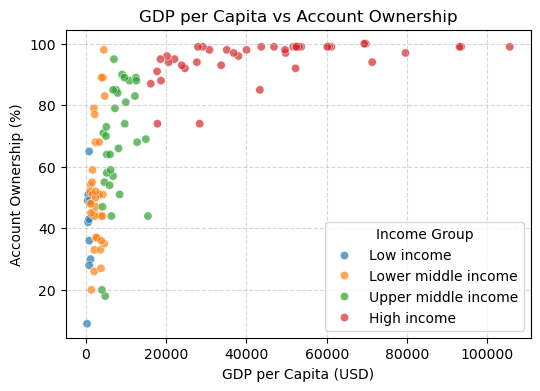

In [26]:
# GDP per Capita vs Account Ownership
plt.figure(dpi=300)
plt.figure(figsize=(6, 4))
sns.scatterplot(data = data, x='GDP_per_capita', y='account_total (%)', hue='income_group', hue_order= income_order, alpha=0.7)
plt.title('GDP per Capita vs Account Ownership')
plt.xlabel('GDP per Capita (USD)')
plt.ylabel('Account Ownership (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Income Group')
plt.show()

GDP per Captita shows positive nonlinear relationship with bank account access.

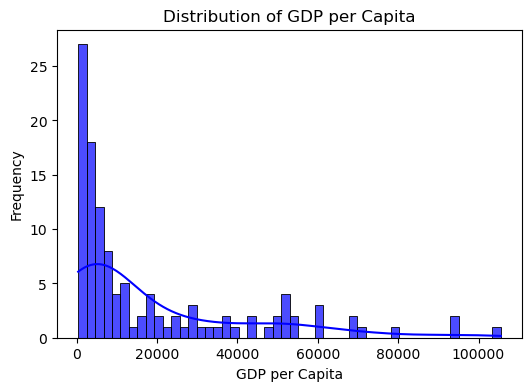

In [27]:
# plot histogram of GDP per Capita

plt.figure(figsize=(6, 4))
sns.histplot(data['GDP_per_capita'], bins=50, kde =True, color='blue', alpha=0.7)
plt.xlabel('GDP per Capita')
plt.ylabel('Frequency')
plt.title('Distribution of GDP per Capita')
plt.show()

GDP data is skewed to the right.

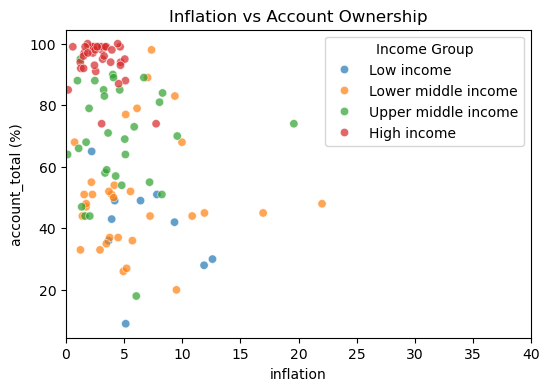

In [28]:
# plot inflation vs account ownership

plt.figure(figsize=(6, 4))
sns.scatterplot(data = data, x='inflation', y='account_total (%)', hue='income_group', hue_order= income_order, alpha=0.7)
plt.title('Inflation vs Account Ownership')
plt.xlim(0, 40)
plt.legend(title='Income Group')
plt.show()

Inflation does not affect the bank account access of the people in the country so much.

In [29]:
# analyze the percentage of account ownership by regions

region_data = data.groupby('region')['account_total (%)'].mean().reset_index()
region_data = region_data.sort_values('account_total (%)', ascending=False)
region_data


,region,account_total (%)
2,High income,95.146341
1,Europe & Central Asia,69.500000
0,East Asia & Pacific,67.625000
3,Latin America & Caribbean,55.384615
6,Sub-Saharan Africa,54.458333
5,South Asia,50.166667
4,Middle East & North Africa,39.777778


In [30]:
# Replace "Hight income" with "High-income economies" in the dataset
region_data['region'] = region_data['region'].replace(
    {'High income': 'High-income economies'}
)
region_data

,region,account_total (%)
2,High-income economies,95.146341
1,Europe & Central Asia,69.500000
0,East Asia & Pacific,67.625000
3,Latin America & Caribbean,55.384615
6,Sub-Saharan Africa,54.458333
5,South Asia,50.166667
4,Middle East & North Africa,39.777778


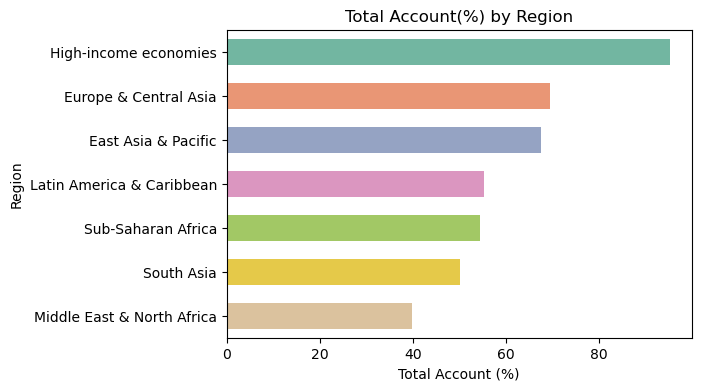

In [31]:
# plot the region data 
plt.figure(figsize=(6, 4))
sns.barplot(x='account_total (%)', y='region', data=region_data, width = 0.6, hue = 'region', palette='Set2')
plt.title('Total Account(%) by Region')
plt.xlabel('Total Account (%)')
plt.ylabel('Region')
plt.show()

In [32]:
# plot interative bar plot of account ownership by region
import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(region_data, x='region', y='account_total (%)', color='region',
                title='Total Account Ownership by Region',
                color_discrete_sequence=px.colors.qualitative.Set2,
                labels={'account_total (%)': 'Account Ownership (%)', 'region': 'Region'})
fig.show()

In [33]:
# filter data for specific countries


# filter data for specific countries
specific_countries = ['United States','Japan', 'China', 'India', 'Germany', 'United Kingdom',  'Kenya', 'Nigeria']

data_countries = data[data['country'].isin(specific_countries)]

# Replace "Hight income" with "High-income economies" in the dataset

data_countries.loc[data_countries['region'] == 'High income', 'region'] = 'High-income economies'
data_countries 

,country,code,GDP_per_capita,inflation,region,income_group,account_total (%),account_female (%),account_male (%),account_primary_edu (%),account_secondary_edu (%),gender_gap,education_gap,high_account_access
102,Kenya,KEN,2061.356221,6.107936,Sub-Saharan Africa,Lower middle income,79.0,75.0,83.0,61.0,88.0,8.0,27.0,1
91,India,IND,2239.613844,5.131407,South Asia,Lower middle income,77.0,77.0,77.0,75.0,81.0,0.0,6.0,1
148,Nigeria,NGA,2017.274865,16.952846,Sub-Saharan Africa,Lower middle income,45.0,34.0,55.0,25.0,65.0,21.0,40.0,0
33,China,CHN,12617.505100,0.981015,East Asia & Pacific,Upper middle income,88.0,87.0,89.0,83.0,97.0,2.0,14.0,1
67,United Kingdom,GBR,46896.866240,2.518371,High-income economies,High income,99.0,99.0,99.0,98.0,99.0,0.0,1.0,1
212,United States,USA,71318.307360,4.697859,High-income economies,High income,94.0,96.0,93.0,57.0,96.0,-3.0,39.0,1
43,Germany,DEU,52265.654160,3.066667,High-income economies,High income,99.0,100.0,99.0,100.0,99.0,-1.0,-1.0,1
100,Japan,JPN,40058.537330,-0.233353,High-income economies,High income,98.0,98.0,98.0,94.0,99.0,0.0,5.0,1


In [34]:
# plot interactive country vs account ownership by region
import plotly.express as px
import plotly.graph_objects as go

fig_countries = px.bar(data_countries, x='country', y='account_total (%)', color='region',
                title='Account Ownership by Country',
                color_discrete_sequence=px.colors.qualitative.Set2,
                labels={'account_total (%)': 'Total Account Ownership (%)', 'country': 'Country'})
fig_countries.show()

It’s interesting that about 79% of adults in Kenya hold a bank account (see Fig. 2), which is much higher than the average in Sub-Saharan Africa (54%). Among developing economies, about 88% of adults in China have a bank account, whereas this number is much lower in other developing economies from East Asia.

### **Q2: Are there global differences in bank account ownership between men and women, lower educated and higher educated individuals, and what might explain them?**

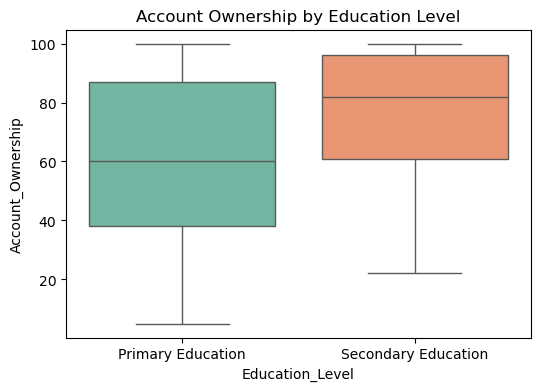

In [35]:
# Education Level vs Account Ownership
edu_data = data[['account_primary_edu (%)', 'account_secondary_edu (%)']].copy()
edu_data = edu_data.melt(var_name='Education_Level', value_name='Account_Ownership')

plt.figure(figsize=(6,4))
sns.boxplot(x='Education_Level', y='Account_Ownership', data=edu_data, hue='Education_Level', palette='Set2')
plt.title('Account Ownership by Education Level')
plt.xticks([0,1], ['Primary Education', 'Secondary Education'])
plt.show()

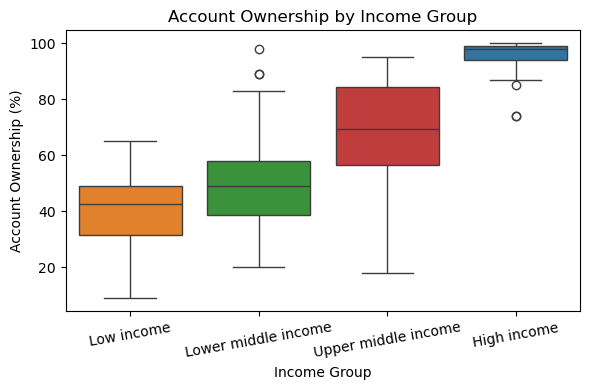

In [36]:
# Account Ownership by Income Group
plt.figure(figsize=(6, 4))
sns.boxplot(x='income_group', y='account_total (%)', hue = 'income_group', order=income_order,
            data=data, )
plt.xticks(rotation=10)
plt.xlabel('Income Group')
plt.ylabel('Account Ownership (%)')
plt.title('Account Ownership by Income Group')
plt.tight_layout()  
plt.show()

Increasing income can increase the likelihood of bank account access.

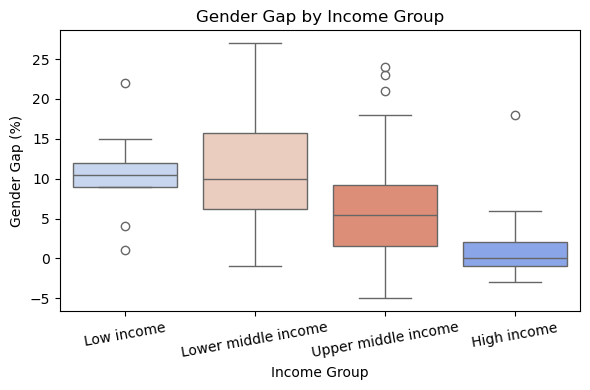

In [37]:
# Gender Gap by Income Group

plt.figure(figsize=(6, 4))
sns.boxplot(x='income_group', y='gender_gap', order=income_order,
            data=data, hue = 'income_group', palette='coolwarm')
plt.xticks(rotation=10)
plt.xlabel('Income Group')
plt.ylabel('Gender Gap (%)')
plt.title('Gender Gap by Income Group')
plt.tight_layout()  
plt.show()

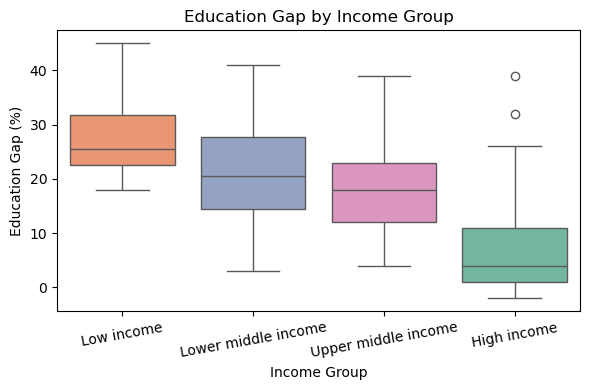

In [38]:
# Education Gap by Income Group

plt.figure(figsize=(6, 4))
sns.boxplot(x='income_group', y='education_gap', order=income_order,
            data=data, hue = 'income_group', palette = 'Set2')
plt.xticks(rotation=10)
plt.xlabel('Income Group')
plt.ylabel('Education Gap (%)')
plt.title('Education Gap by Income Group')
plt.tight_layout()  
plt.show()

Incresing income can narrow the gender gap and education gap in bank account ownership.

In [39]:
# Group and aggregate, then reset index to make income_group a column
group_data = data.groupby('income_group', observed=True).agg({
    'gender_gap': 'mean',
    'education_gap': 'mean'
}).reset_index()

# Now apply categorical sorting as before
income_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']
group_data['income_group'] = pd.Categorical(group_data['income_group'], 
                                          categories=income_order,
                                          ordered=True)
group_data.sort_values('income_group', inplace=True)

group_data.head()

,income_group,gender_gap,education_gap
1,Low income,10.500000,27.700000
2,Lower middle income,10.794118,20.911765
3,Upper middle income,6.375000,18.125000
0,High income,1.000000,8.000000


<Figure size 400x400 with 0 Axes>

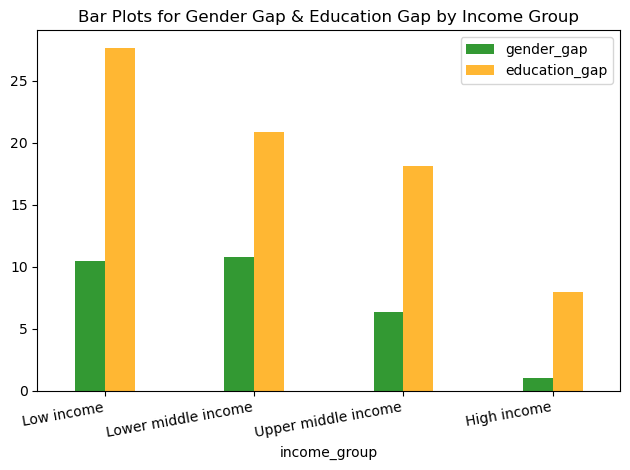

In [40]:
# Bar Plots for Gender Gap and Education Gap by Income Group
plt.figure(figsize=(4, 4))

group_data.set_index('income_group').plot(kind='bar', width=0.4, stacked=False, alpha=0.8,  color=['green', 'orange'])
plt.title('Bar Plots for Gender Gap & Education Gap by Income Group')
plt.xticks(rotation=10, ha='right')
plt.xlabel('income_group')
plt.legend()
plt.tight_layout()
plt.show()




The gap caused by education levels in bank account ownership is larger than the gap caused by gender.

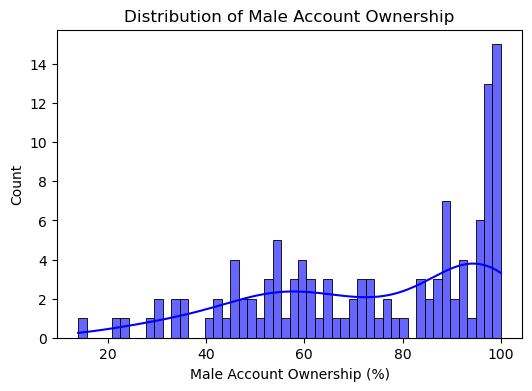

In [41]:
# plot the male account ownership distribution

plt.figure(figsize=(6,4))
sns.histplot(data['account_male (%)'], kde=True, bins=50, color='blue', alpha=0.6)
plt.title('Distribution of Male Account Ownership')
plt.xlabel('Male Account Ownership (%)')
plt.show()

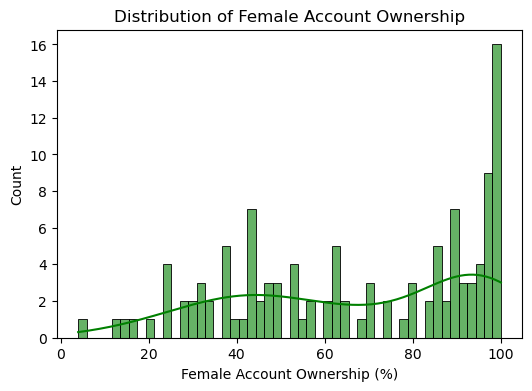

In [42]:
# plot the female account ownership distribution

plt.figure(figsize=(6,4))
sns.histplot(data['account_female (%)'], kde=True, bins=50, color='green', alpha=0.6)
plt.title('Distribution of Female Account Ownership')
plt.xlabel('Female Account Ownership (%)')
plt.show()

The distribution of female and male applicants for the bank account access is similar.

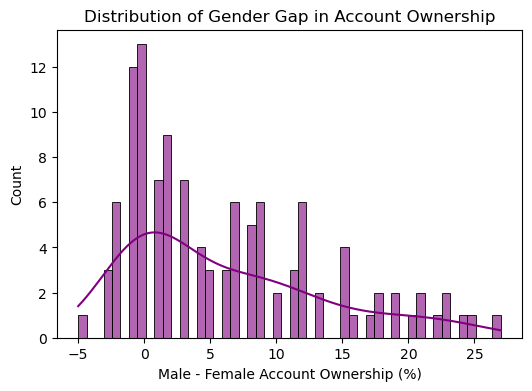

In [43]:
# Gender Gap Histogram
plt.figure(figsize=(6,4))
sns.histplot(data['gender_gap'], kde=True, color='purple', bins=50, alpha=0.6)
plt.title('Distribution of Gender Gap in Account Ownership')
plt.xlabel('Male - Female Account Ownership (%)')
plt.show()

The distribution of the gender gap is skewed to the right.

In [44]:
# define income goup order
income_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

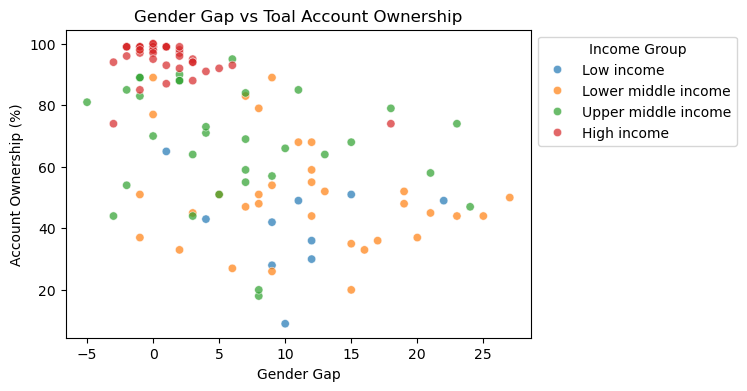

In [45]:
# Gender Gap vs Account Ownership
plt.figure(figsize=(6,4))
sns.scatterplot(data=data, x='gender_gap', y = 'account_total (%)', hue = 'income_group', hue_order=income_order, alpha=0.7)
plt.title('Gender Gap vs Toal Account Ownership')
plt.xlabel('Gender Gap')
plt.ylabel('Account Ownership (%)')
plt.legend(title='Income Group', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

No clear linear relationship between gender gap and bank account access can be seen in the data.

At lower gender gap, the probability of having a bank account is higher.

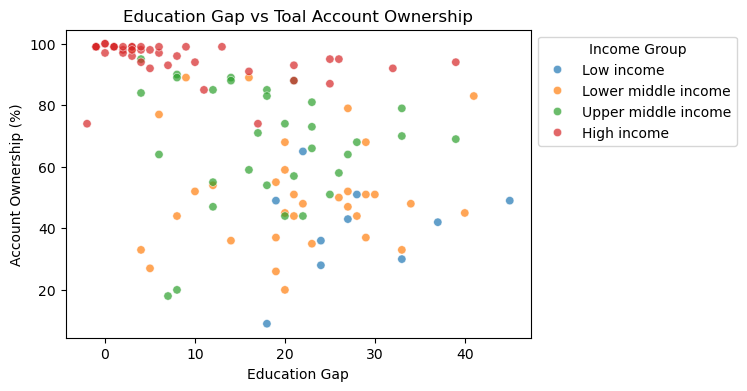

In [46]:
# Education Gap vs Account Ownership
plt.figure(figsize=(6,4))
sns.scatterplot(data=data, x='education_gap', y = 'account_total (%)', hue = 'income_group',hue_order=income_order, alpha=0.7)
plt.title('Education Gap vs Toal Account Ownership')
plt.xlabel('Education Gap')
plt.ylabel('Account Ownership (%)')
plt.legend(title='Income Group', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

With lower education gap, the probability of getting a bank account is higher.

In [47]:
# Create Interactive Gender Gap in Account Ownership by Income Group Map

import plotly.express as px
import plotly.graph_objects as go


fig = px.choropleth(data,
                    locations="code",
                    color="gender_gap",
                    hover_name="country",
                    animation_frame="income_group",
                    scope='world',
                    range_color=[-10, 30],  # 100-100% scale
                    color_continuous_scale='Viridis',
                    title='Gender Gap Map in Account Ownership by Income Group'
                    )

# Enhance the layout
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    coloraxis_colorbar=dict(
        title='Gender Gap (%)',
        thickness=20,
        len=0.75
    ),
    margin={"r":0,"t":40,"l":0,"b":0}
)

# Add play/pause button for animation
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 800
fig.show()

High-income countries have a lower gender gap compared to low-income countries, except for the Saudi Arabia, which has a higher gender gap among high-income countries. This can be attributed to religious beliefs and cultural practices, which may limit women's access to bank accounts and financial services.

In [48]:
# Create Interactive Education Gap in Account Ownership by Income Group Map
import plotly.express as px
import plotly.graph_objects as go


fig = px.choropleth(data,
                    locations="code",
                    color="education_gap",
                    hover_name="country",
                    animation_frame="income_group",
                    scope='world',
                    range_color=[-10, 50], 
                    color_continuous_scale = px.colors.sequential.Plasma,
                    title='Education Gap Map in Account Ownership by Income Group'
                    )

# Enhance the layout
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    coloraxis_colorbar=dict(
        title='Education Gap (%)',
        thickness=20,
        len=0.75
    ),
    margin={"r":0,"t":40,"l":0,"b":0}
)

# Add play/pause button for animation
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 800
fig.show()

High-income countries have lower education gap than low-income countries, except for the United States, which has a relatively high education gap. This may be related to a relatively large wealth inequality in the United States as compared to other high-income countries. 

In [49]:
# Create Gender Gap in Account Ownership
import plotly.express as px
import plotly.graph_objects as go


fig = px.choropleth(data,
                    locations="code",
                    color="gender_gap",
                    hover_name="country",
                    scope='world',
                    range_color=[-10, 30],  # 0-100% scale
                    color_continuous_scale='Viridis',
                    title='Gender Gap Map in Account Ownership by Income Group'
                    )

# Enhance the layout
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    coloraxis_colorbar=dict(
        title='Gender Gap (%)',
        thickness=20,
        len=0.75
    ),
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()

In [50]:
# Create Education Gap in Account Ownership
import plotly.express as px
import plotly.graph_objects as go


fig = px.choropleth(data,
                    locations="code",
                    color="education_gap",
                    hover_name="country",
                    scope='world',
                    range_color=[-10, 50], 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Education Gap Map in Account Ownership by Income Group'
                    )

# Enhance the layout
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    coloraxis_colorbar=dict(
        title='Education Gap (%)',
        thickness=20,
        len=0.75
    ),
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()

In [51]:
# save the interactive plot as html file
fig_countries.write_html('account_ownership_by_country.html')

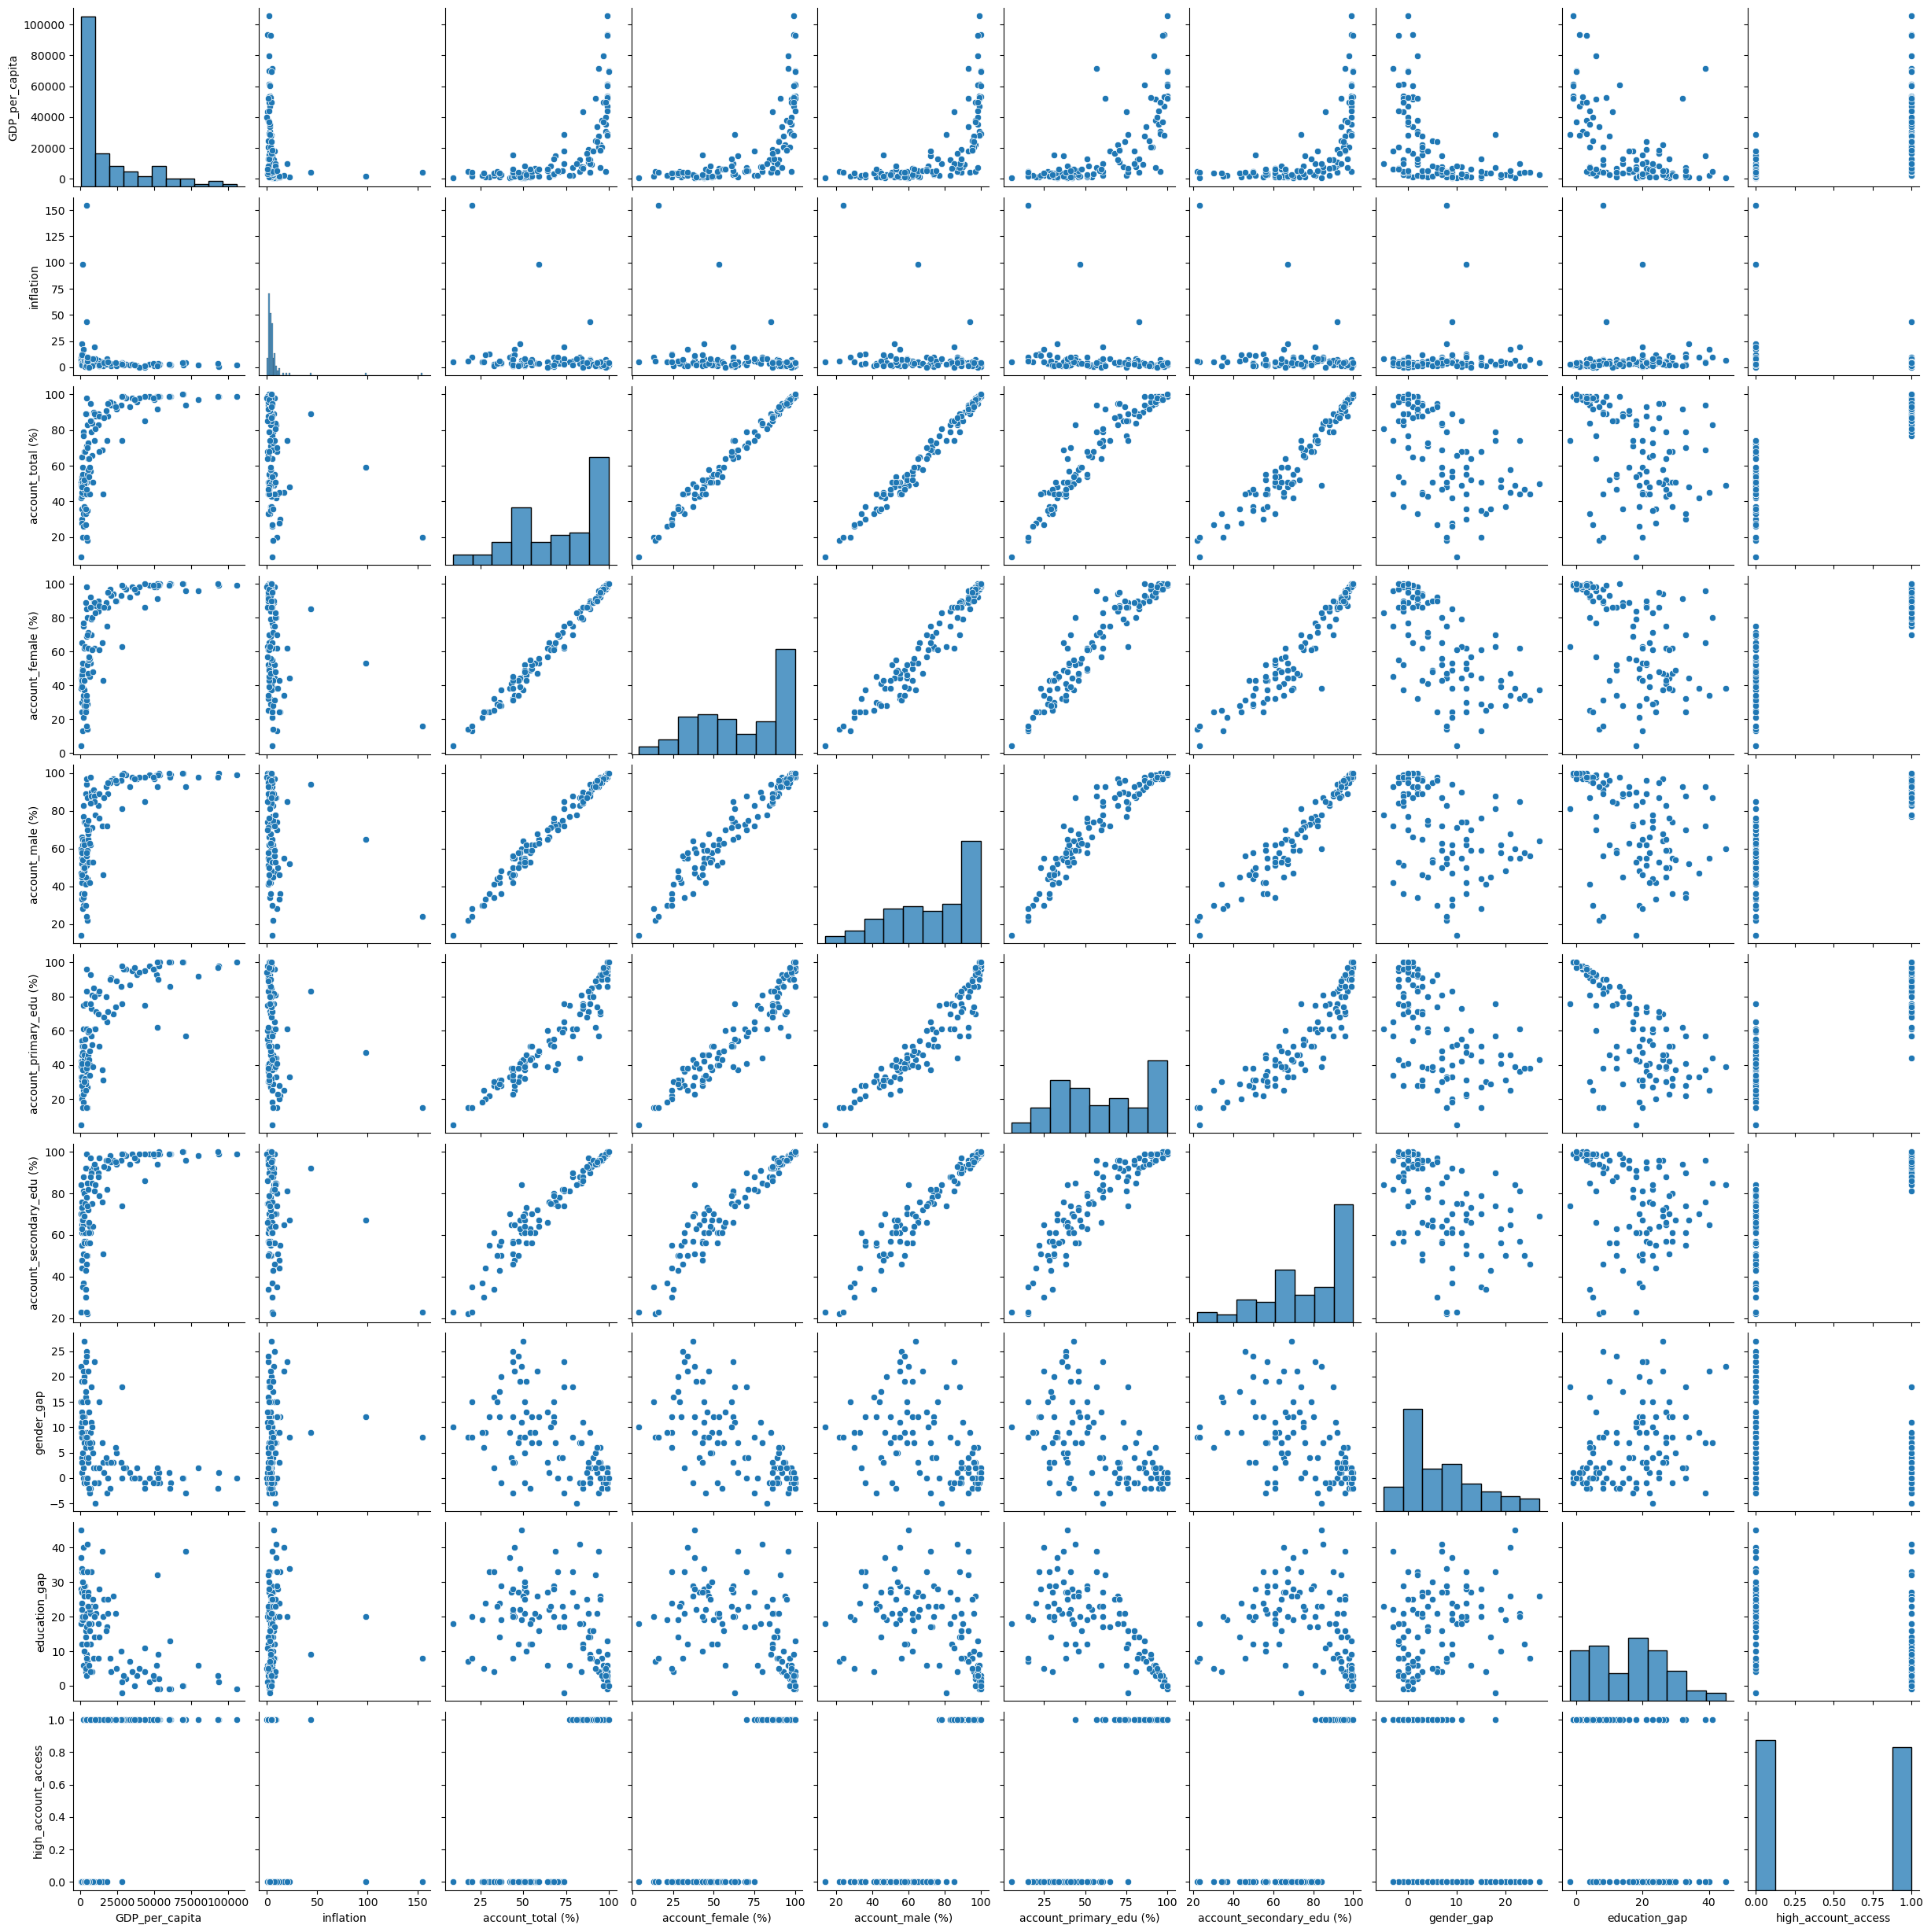

In [52]:
# check relationship between features
sns.pairplot(data)
plt.show()

## Data Preparation

### Encode categorical variables


In [53]:
# encode income_group as numerical values with one-hot encoding

data_encoded = pd.get_dummies(
    data, 
    columns=['income_group'],
    drop_first=False,  # # Keep all categories
    dtype='int'      # Ensures the dummies are integers
)
data_encoded.head()

,country,code,GDP_per_capita,inflation,region,account_total (%),account_female (%),account_male (%),account_primary_edu (%),account_secondary_edu (%),gender_gap,education_gap,high_account_access,income_group_High income,income_group_Low income,income_group_Lower middle income,income_group_Upper middle income
1,Afghanistan,AFG,356.496214,5.133203,South Asia,9.0,4.0,14.0,5.0,23.0,10.0,18.0,0,0,1,0,0
143,Malawi,MWI,617.447521,9.330144,Sub-Saharan Africa,42.0,38.0,47.0,33.0,70.0,9.0,37.0,0,0,1,0,0
70,Guinea,GIN,1244.965505,12.597288,Sub-Saharan Africa,30.0,24.0,36.0,22.0,55.0,12.0,33.0,0,0,1,0,0
112,Liberia,LBR,667.966105,7.815594,Sub-Saharan Africa,51.0,44.0,59.0,42.0,70.0,15.0,28.0,0,0,1,0,0
140,Mozambique,MOZ,509.907829,6.408477,Sub-Saharan Africa,49.0,38.0,60.0,39.0,84.0,22.0,45.0,0,0,1,0,0


In [54]:
data.income_group.value_counts()

income_group
High income            41
Lower middle income    34
Upper middle income    32
Low income             10
Name: count, dtype: int64

In [55]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 1 to 95
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country                           117 non-null    object 
 1   code                              117 non-null    object 
 2   GDP_per_capita                    117 non-null    float64
 3   inflation                         117 non-null    float64
 4   region                            117 non-null    object 
 5   account_total (%)                 117 non-null    float64
 6   account_female (%)                117 non-null    float64
 7   account_male (%)                  117 non-null    float64
 8   account_primary_edu (%)           117 non-null    float64
 9   account_secondary_edu (%)         117 non-null    float64
 10  gender_gap                        117 non-null    float64
 11  education_gap                     117 non-null    float64
 12  high_account_a

### Transform data

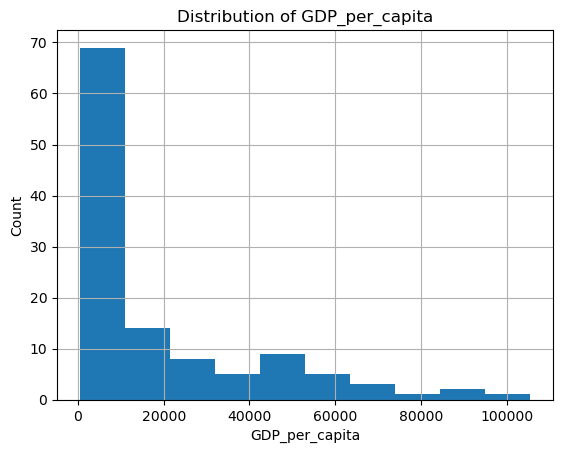

In [56]:
# check GDP per capita distribution
data_encoded['GDP_per_capita'].hist()
plt.title('Distribution of GDP_per_capita')
plt.xlabel('GDP_per_capita')
plt.ylabel('Count')
plt.show()

In [57]:
# use logtranformation for GDP per capita to reduce skewness
data_encoded['GDP_per_capita'] = np.log(data_encoded['GDP_per_capita'] + 1)

# check skewness of gdp_per_capita
data_encoded['GDP_per_capita'].skew()

-0.009240542845667176

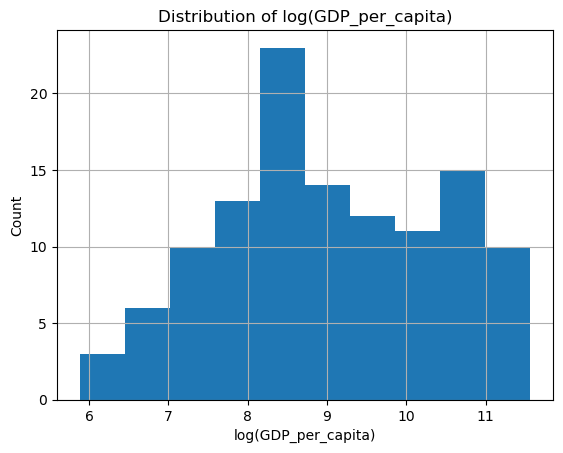

In [58]:
data_encoded['GDP_per_capita'].hist()
plt.title('Distribution of log(GDP_per_capita)')
plt.xlabel('log(GDP_per_capita)')
plt.ylabel('Count')
plt.show()

In [59]:
# Scale features using StandardScaler

scaler = StandardScaler()
columns_to_scale = ['GDP_per_capita', 'inflation', 'account_male (%)', 'account_female (%)', 
                    'account_primary_edu (%)', 'account_secondary_edu (%)', 'gender_gap', 'education_gap']

data_encoded[columns_to_scale] = scaler.fit_transform(data_encoded[columns_to_scale])

In [60]:
data_encoded.head()

,country,code,GDP_per_capita,inflation,region,account_total (%),account_female (%),account_male (%),account_primary_edu (%),account_secondary_edu (%),gender_gap,education_gap,high_account_access,income_group_High income,income_group_Low income,income_group_Lower middle income,income_group_Upper middle income
1,Afghanistan,AFG,-2.218887,-0.105821,South Asia,9.0,-2.319265,-2.583580,-2.082520,-2.600973,0.520214,0.156849,0,0,1,0,0
143,Malawi,MWI,-1.828023,0.141231,Sub-Saharan Africa,42.0,-1.075864,-1.151801,-1.040306,-0.343594,0.385854,1.817208,0,0,1,0,0
70,Guinea,GIN,-1.328501,0.333550,Sub-Saharan Africa,30.0,-1.587853,-1.629061,-1.449747,-1.064035,0.788933,1.467658,0,0,1,0,0
112,Liberia,LBR,-1.772027,0.052077,Sub-Saharan Africa,51.0,-0.856440,-0.631154,-0.705308,-0.343594,1.192013,1.030722,0,0,1,0,0
140,Mozambique,MOZ,-1.964250,-0.030752,Sub-Saharan Africa,49.0,-1.075864,-0.587767,-0.816974,0.328816,2.132531,2.516306,0,0,1,0,0


## Modeling 

### **Q3: Can we predict bank account access based on GDP per capita, income, gender and education levels?** 

### Linear Regression

In [61]:
# select features and target variable

X = data_encoded[['GDP_per_capita']]
y = data_encoded['account_total (%)']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
from sklearn.linear_model import LinearRegression
# Create and train model

ln = LinearRegression()
ln.fit(X_train, y_train)

LinearRegression()

In [63]:
y_pred = ln.predict(X_test)

In [64]:
# evaluate model performance

from sklearn.metrics import mean_squared_error, r2_score

MSE = mean_squared_error(y_test, y_pred)
R2_score = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {MSE}')
print(f'R2 Score: {R2_score}')

Mean Squared Error: 201.1867223002123
R2 Score: 0.6335106940726496


R2 score is relatively low and MSE is relatively large, indicating that linear regression is not a good model to predict bank account access based on GDP per capita data.

### Classification Models 

In [65]:
# prepare data for classification
# select features and target variable

X = data_encoded[[ 'gender_gap',
       'education_gap', 'income_group_High income',
       'income_group_Low income', 'income_group_Lower middle income',
       'income_group_Upper middle income']]
y = data_encoded['high_account_access']

In [66]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
X_test.shape, y_test.shape

((24, 6), (24,))

###  **1. Logistic Regression**

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_auc_score

# Create and train model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [69]:
# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

y_pred_prob_log_reg = log_reg.predict_proba(X_test)[:,1]  # Get probabilities for the positive class (1)

print(f'The possibility of high account access is: \n{y_pred_prob_log_reg}')

The possibility of high account access is: 
[0.17054205 0.00370382 0.31207174 0.022138   0.10919341 0.95757429
 0.23202918 0.9705618  0.12643542 0.23337675 0.05162855 0.09233194
 0.97590075 0.96818509 0.43905616 0.12056679 0.71846245 0.92496435
 0.95786497 0.97445439 0.0328242  0.96629166 0.6835503  0.61901471]


In [70]:
# evaluate model performance

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.2f}")

# Confusion Matrix
print(f"\nConfusion Matrix: \n { confusion_matrix(y_test, y_pred_log_reg)}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob_log_reg)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

Accuracy: 0.79

Confusion Matrix: 
 [[10  2]
 [ 3  9]]

ROC-AUC Score: 0.85


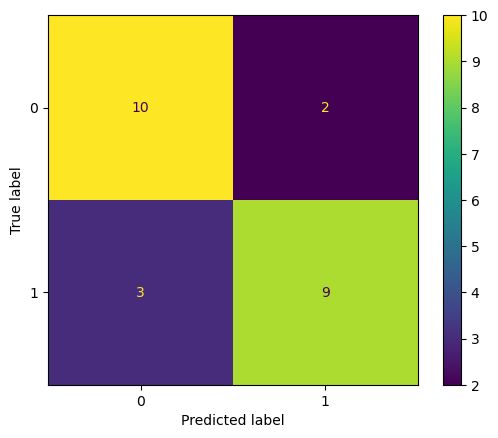

In [71]:
# plotting confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_log_reg)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


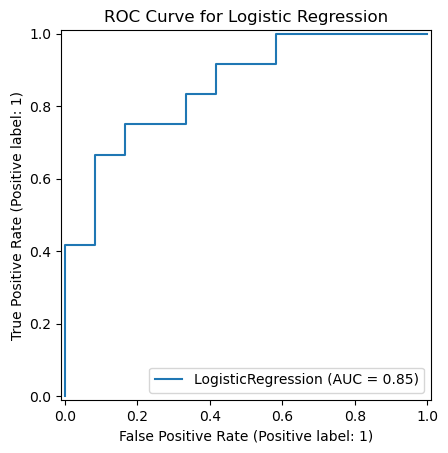

In [72]:
# plot ROC curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve for Logistic Regression")
plt.show()

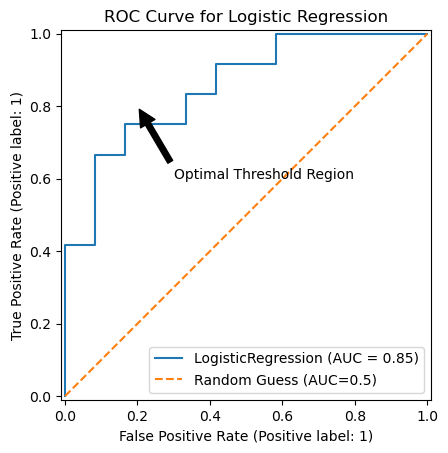

In [73]:
# add random guess line and annotations

RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess (AUC=0.5)')
plt.annotate(f'Optimal Threshold Region', xy=(0.2, 0.8), xytext=(0.3, 0.6),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.show()

AUC = 0.85 suggests that the model is good at predicting the probability of a person being granted bank account access.

The ROC curve evaluates how well our model distinguishes between people with high vs. low bank account access. The closer the curve is to the top-left corner, the better the model performs.

In [74]:
# generate classification Report (Precision, Recall, F1)

from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg))


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24



In [75]:
# interpret feature importance

# get coefficients (log-odds)
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop Influential Features:")
print(importance.head())


Top Influential Features:
                            Feature  Coefficient
2          income_group_High income     2.002125
0                        gender_gap    -1.236651
3           income_group_Low income    -0.888977
4  income_group_Lower middle income    -0.795312
1                     education_gap    -0.683942


- Positive coefficients: increase the likelihood of high_account_access.
- Negative coefficients: decrease the likelihood.

###  **2. Random Forest**

In [76]:
# creat random forest model

from sklearn.ensemble import RandomForestClassifier

# Create and train model

rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,       # Control tree depth (avoid overfitting)
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [77]:
# generate predictions
y_pred_rf = rf_model.predict(X_test)

# Get probabilities for the positive class (1)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]  

In [78]:
# calculate metrics

accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
print(f"\nConfusion Matrix: \n { confusion_matrix(y_test, y_pred_rf)}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


# ROC-AUC Score
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print(f"ROC AUC Score: {roc_auc_rf:.2f}")


Accuracy: 0.79

Confusion Matrix: 
 [[10  2]
 [ 3  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

ROC AUC Score: 0.76


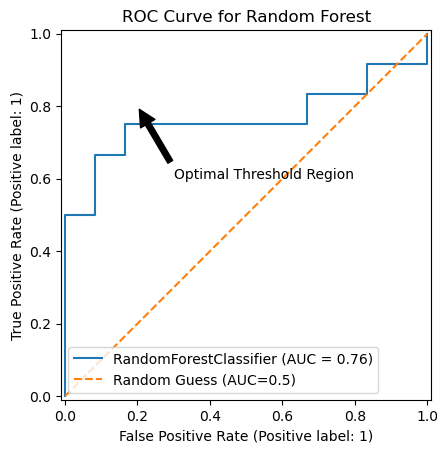

In [79]:
# plot ROC curve

RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve for Random Forest")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess (AUC=0.5)')
plt.annotate(f'Optimal Threshold Region', xy=(0.2, 0.8), xytext=(0.3, 0.6),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()
plt.show()

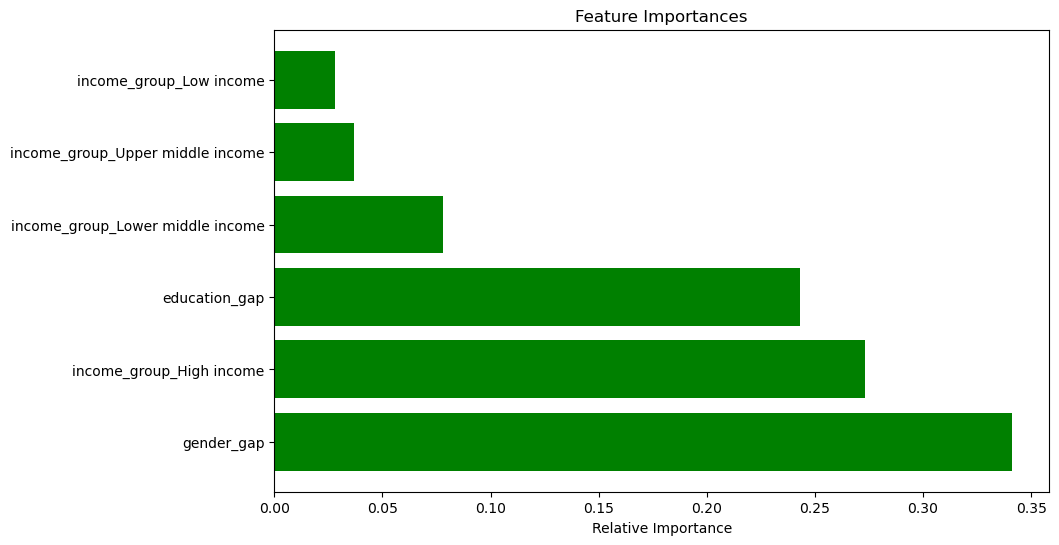

In [80]:
# feature importance

importances = rf_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[:-10:-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

AUC score for random forest model is 0.76, which is lower than the AUC score of 0.85 for logistic regression model.

Gender_gap, high_income group and education_gap have the most impact on bank account access.

### **3. XGBoost model**

In [81]:
import xgboost as xgb

# # Initialize and train the model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    n_estimators=100,            # Number of trees
    max_depth=3,                 # Control tree depth (avoid overfitting)
    learning_rate=0.1,           # Step size shrinkage
    subsample=0.8,               # Fraction of samples per tree
    colsample_bytree=0.8,        # Fraction of features per tree
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [82]:
# generate predictions

y_pred_xgb = xgb_model.predict(X_test)

# Get probabilities for the positive class (1)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [83]:
# calculate metrics

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
print(f"\nConfusion Matrix: \n { confusion_matrix(y_test, y_pred_xgb)}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


# ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
print(f"ROC AUC Score: {roc_auc_xgb:.2f}")


Accuracy: 0.79

Confusion Matrix: 
 [[10  2]
 [ 3  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

ROC AUC Score: 0.77


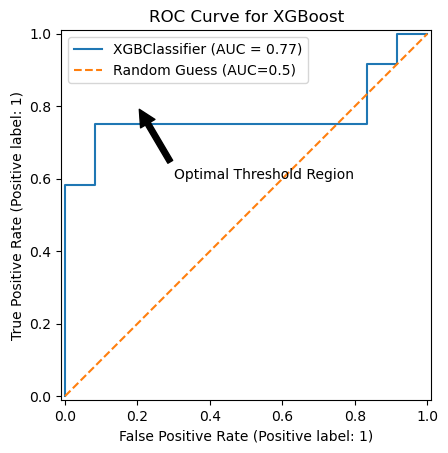

In [84]:
# plot ROC curve

RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("ROC Curve for XGBoost")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess (AUC=0.5)')
plt.annotate(f'Optimal Threshold Region', xy=(0.2, 0.8), xytext=(0.3, 0.6),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()
plt.show()

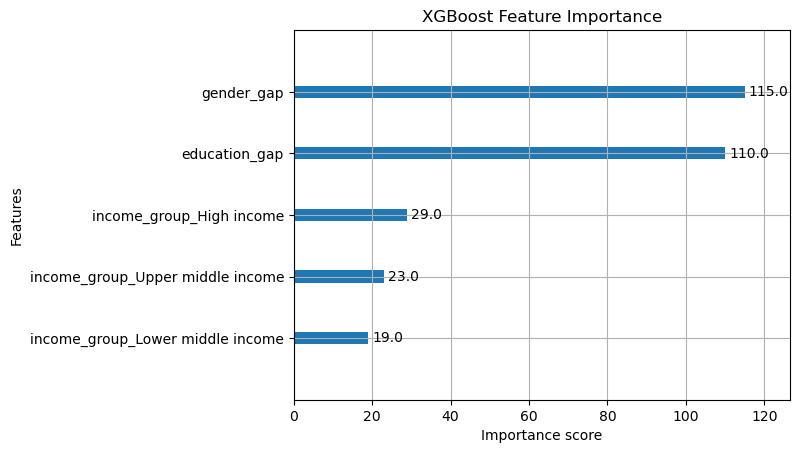

In [85]:
# feature importance

xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

## Evaluation

In [86]:
# Define a function to compute metrics consistently:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_true, y_pred, y_prob, model_name):
    """
    Evaluate a machine learning model using various metrics and return a dictionary of results.
    Parameters:
    y_true (array-like): True labels of the data.
    y_pred (array-like): Predicted labels of the data.
    y_prob (array-like): Predicted probabilities of the positive class.
    model_name (str): Name of the model being evaluated.
    Returns:
    dict: Dictionary containing the evaluation metrics for the model.

    """
    # Calculate and store the evaluation metrics in a dictionary
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_prob)
    }
    return metrics

In [87]:
# apply the function to each model's predictions

results = []
models = {
    'Logistic Regression': (y_pred_log_reg, y_pred_prob_log_reg),
    'Random Forest': (y_pred_rf, y_pred_prob_rf),
    'XGBoost': (y_pred_xgb, y_pred_prob_xgb)
}

for name, (y_pred, y_prob) in models.items():
    results.append(evaluate_model(y_test, y_pred, y_prob, name))

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df.round(3))

                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression     0.792      0.818    0.75     0.783    0.854
1        Random Forest     0.792      0.818    0.75     0.783    0.764
2              XGBoost     0.792      0.818    0.75     0.783    0.771


<Figure size 1000x600 with 0 Axes>

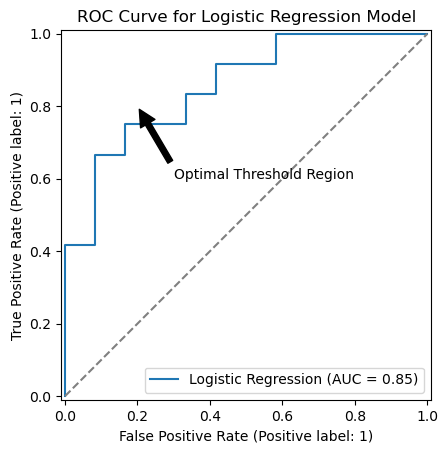

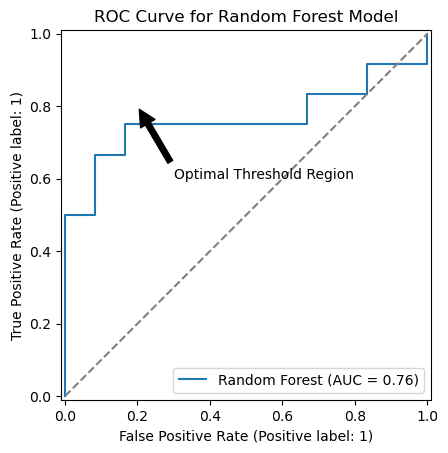

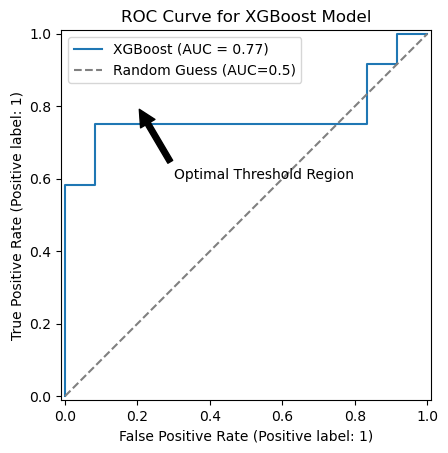

In [88]:
# ROC Curve for all models

plt.figure(figsize=(10, 6))
for name, model in [('Logistic Regression', log_reg), 
                    ('Random Forest', rf_model), 
                    ('XGBoost', xgb_model)]:
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name),
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC=0.5)'),
    plt.annotate(f'Optimal Threshold Region', xy=(0.2, 0.8), xytext=(0.3, 0.6),
             arrowprops=dict(facecolor='black', shrink=0.05))
    plt.title(f"ROC Curve for {name} Model")

plt.legend()
plt.show()

- Three models (Logistic Regression, Random Forest, and XGBoost) have identical Accuracy, Precision, Recall, and F1-Score, but Logistic Regression has a significantly higher ROC-AUC (0.854) compared to the others (0.764 and 0.771).

- Logistic Regression is the best model for this dataset to predict whether a bank account will be accessed or not.

In [89]:
# training and testing datasets for each model to check for overfitting.
train_accuracy = {
    'Logistic Regression': accuracy_score(y_train, log_reg.predict(X_train)),
    'Random Forest': accuracy_score(y_train, rf_model.predict(X_train)),
    'XGBoost': accuracy_score(y_train, xgb_model.predict(X_train))}
print("Training Accuracy:", train_accuracy)

test_accuracy = {
    'Logistic Regression': accuracy_score(y_test, log_reg.predict(X_test)),
    'Random Forest': accuracy_score(y_test, rf_model.predict(X_test)),
    'XGBoost': accuracy_score(y_test, xgb_model.predict(X_test))}
print("Testing Accuracy:", test_accuracy)

# Compare the training and testing accuracy for each model
for model in train_accuracy.keys():
    print(f"{model} - Train Accuracy: {train_accuracy[model]:.2f}, Test Accuracy: {test_accuracy[model]:.2f}")
    if train_accuracy[model] - test_accuracy[model] > 0.1:
        print(f"{model} may be overfitting.")
    else:
        print(f"{model} is not overfitting.")

Training Accuracy: {'Logistic Regression': 0.9247311827956989, 'Random Forest': 0.967741935483871, 'XGBoost': 0.956989247311828}
Testing Accuracy: {'Logistic Regression': 0.7916666666666666, 'Random Forest': 0.7916666666666666, 'XGBoost': 0.7916666666666666}
Logistic Regression - Train Accuracy: 0.92, Test Accuracy: 0.79
Logistic Regression may be overfitting.
Random Forest - Train Accuracy: 0.97, Test Accuracy: 0.79
Random Forest may be overfitting.
XGBoost - Train Accuracy: 0.96, Test Accuracy: 0.79
XGBoost may be overfitting.


It suggests there is overfitting in these models, maybe because of the small sample size.

high_account_access
0    48
1    45
Name: count, dtype: int64


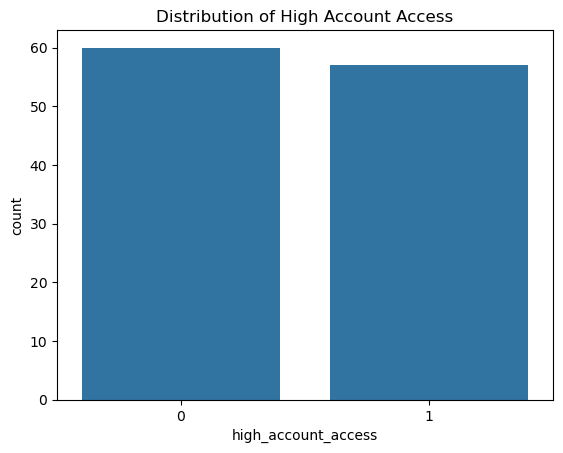

In [90]:
# check for class imbalance
print(y_train.value_counts()) 

sns.countplot(x='high_account_access', data=data_encoded)
plt.title('Distribution of High Account Access')
plt.show()

## **Conclusion:**

1. Economy has significant impact on account access. However, living in a rich country does not mean you'll automatically have a bank account. The account access is affected by multiple factors.

2. The education gap and gender gap in bank account access can be narrowed by increasing income. In general, education level has a greater impact than gender on account access.

3. Logistic regression classification model can effectively predict the account access class based on income, education gap and gender gap. This can be helpful for policy decisions and interventions that can enhance access to banking services for all, particularly focusing on vulnerable groups such as low-income individuals and females in specific regions. 

